In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook
from itertools import product

import warnings
warnings.filterwarnings('ignore')

data=pd.read_csv('/Users/qq/Desktop/stock-prediction-master/stock_prices_sample.csv', index_col=['DATE'], parse_dates=['DATE'])
data.head()

,TICKER,FIGI,TYPE,FREQUENCY,OPEN,HIGH,LOW,CLOSE,VOLUME,ADJ_OPEN,ADJ_HIGH,ADJ_LOW,ADJ_CLOSE,ADJ_VOLUME,ADJ_FACTOR,EX_DIVIDEND,SPLIT_RATIO
DATE,,,,,,,,,,,,,,,,,
2013-01-04,GEF,BBG000BLFQH8,EOD,daily,46.31,47.6198,46.23,47.37,248000.0,38.517220,39.606614,38.450681,39.398849,248000.0,NaN,0.0,1.0
2013-01-03,GEF,BBG000BLFQH8,EOD,daily,46.43,46.5200,46.14,46.48,131300.0,38.617027,38.691882,38.375826,38.658613,131300.0,NaN,0.0,1.0
2013-01-02,GEF,BBG000BLFQH8,EOD,daily,45.38,46.5400,45.16,46.41,184900.0,37.743715,38.708516,37.560735,38.600392,184900.0,NaN,0.0,1.0
2018-06-05,GF,BBG000C3C6S2,Intraday,daily,18.86,18.9100,18.87,18.87,10000.0,18.860000,18.910000,18.870000,18.870000,10000.0,NaN,0.0,1.0
2018-06-04,GF,BBG000C3C6S2,EOD,daily,18.86,18.8900,18.79,18.81,39095.0,18.860000,18.890000,18.790000,18.810000,39095.0,NaN,0.0,1.0


### Clean Data

In [119]:
drop_cols=['TYPE','FIGI','ADJ_FACTOR', 'ADJ_VOLUME', 'ADJ_CLOSE', 'ADJ_LOW', 'ADJ_HIGH', 'ADJ_OPEN','VOLUME','EX_DIVIDEND','FREQUENCY','SPLIT_RATIO']
data = data[data.TICKER != 'GEF']
data.drop(drop_cols,axis=1,inplace=True)
data.head(10)

,TICKER,OPEN,HIGH,LOW,CLOSE
DATE,,,,,
2018-06-05,GF,18.86,18.910,18.8700,18.8700
2018-06-04,GF,18.86,18.890,18.7900,18.8100
2018-06-01,GF,18.58,18.760,18.5800,18.7400
2018-05-31,GF,18.52,18.520,18.3012,18.4900
2018-05-30,GF,18.47,18.678,18.4700,18.6500
2018-05-29,GF,18.51,18.510,18.1500,18.2562
2018-05-25,GF,18.76,18.880,18.7600,18.8420
2018-05-24,GF,18.78,18.780,18.6399,18.7500
2018-05-23,GF,18.83,18.910,18.8100,18.9100


### EDA

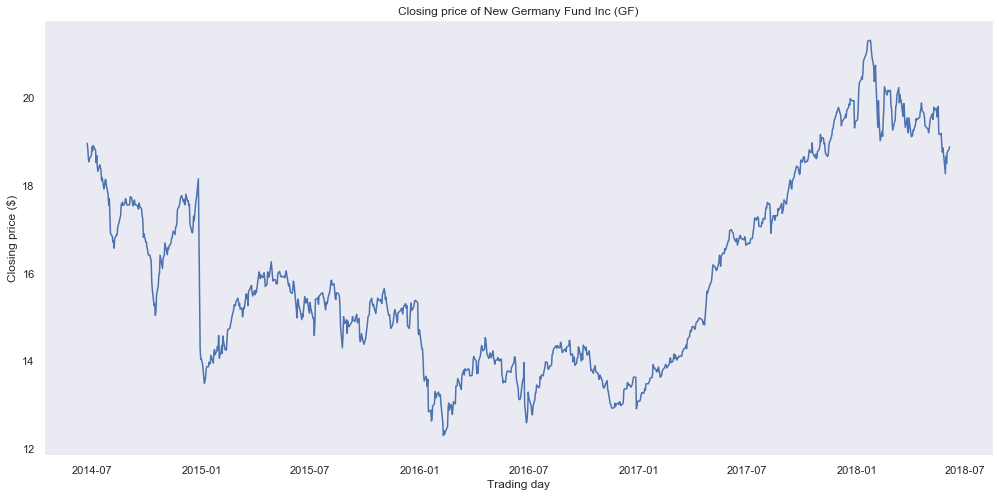

In [34]:
plt.figure(figsize=(17, 8))
plt.plot(data['CLOSE'])
plt.title('Closing price of New Germany Fund Inc (GF)')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
plt.grid(False)
plt.show()

# Process:



###  1.Check stationarity
###  2.Remove non-stationarity
         -differenceing
         -moving average
         -exponential smoothing
### 3.Predict future: ARIMA model

## 1. Check stationarity (using Dickey-Fuller test)

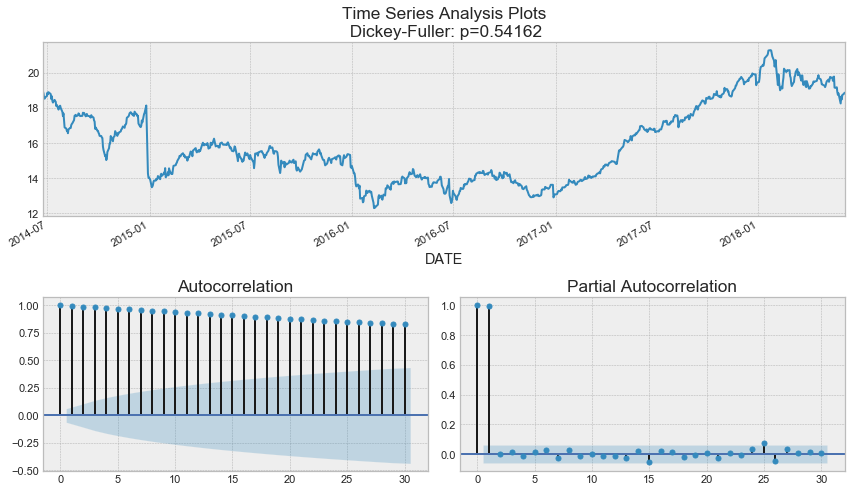

In [55]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        y.plot(ax=ts_ax)
        
        # apply Dickey-Fuller test:
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(data['CLOSE'], lags=30)

#### By the result of the test, p-value>0.05, representing that the data is not stationary. And the autocorrelation is pretty high. According to the pacf plot, the partial autocorrelation between of the 0th and 1st is very large. That means we need to take first difference ( lag=1).

## 2. Turning data into stationary

### 2.1 differencing

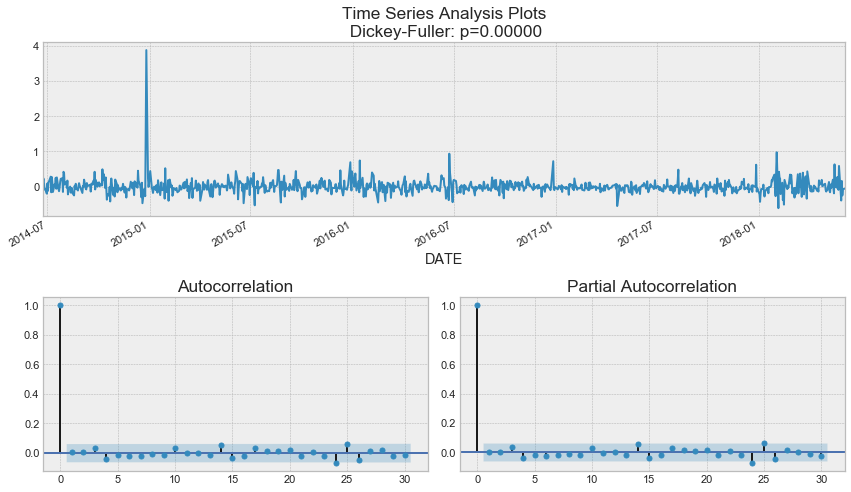

In [52]:
# Take the first difference to remove to make the process stationary
data_diff = data['CLOSE'] - data['CLOSE'].shift(1)
tsplot(data_diff[1:], lags=30)

#### Now, the test showsa p-value of 0. The current time series after taking a lag=1 is stationary. Both acf and pacf support this: Autocorrelationa and partial autocorrelation are both small.

### 2.2 Moving Average

In [37]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

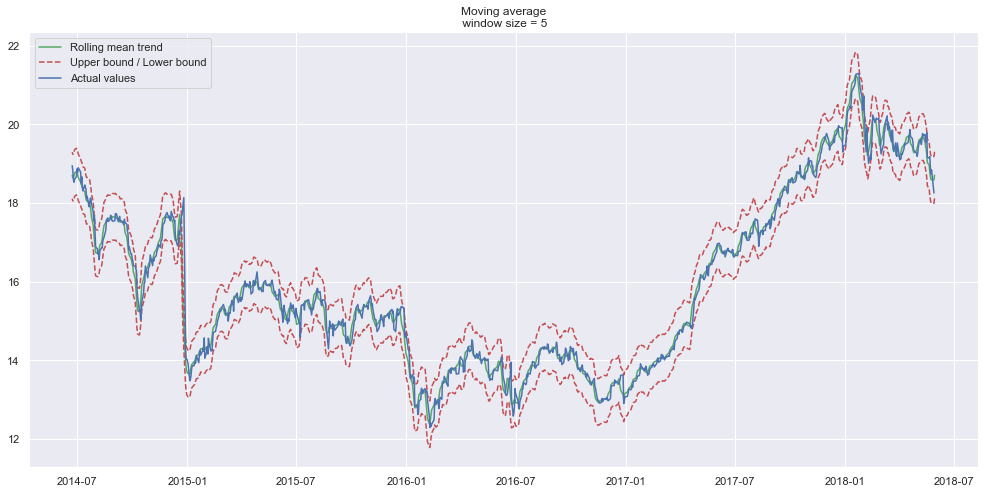

In [43]:
plot_moving_average(data['CLOSE'], 5,plot_intervals=True)


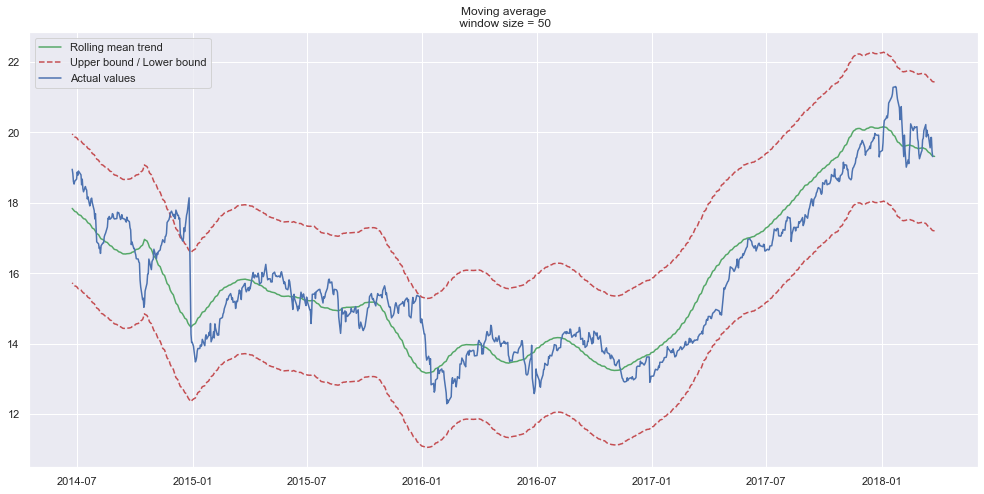

In [44]:
plot_moving_average(data['CLOSE'], 50,plot_intervals=True)

The bigger time interval you use, the smoother the curve is. As you can see from above plot, when we use 50 days as a window, the line get smoother, and show a decreasing trend at the end.

### 2.3 Exponential smoothing

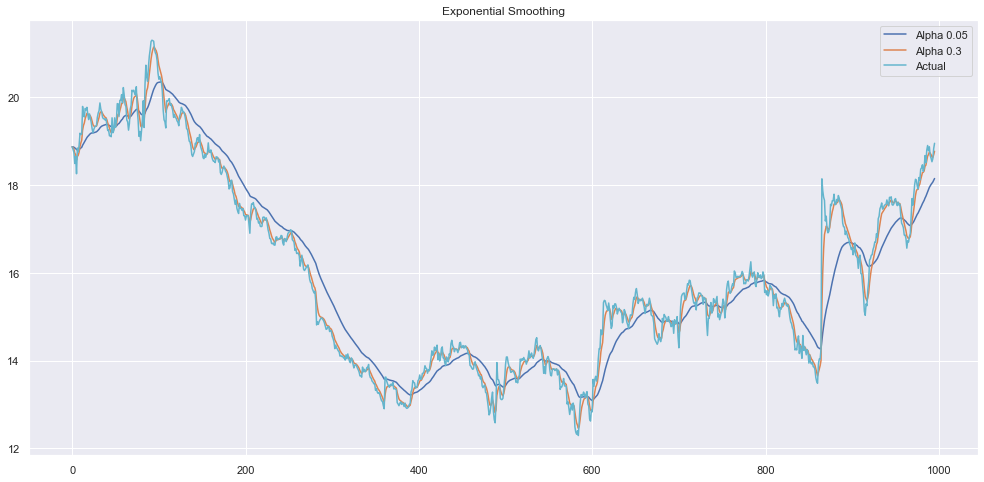

In [45]:
def exponential_smoothing(series, alpha):

    Y = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        Y.append(alpha * series[n] + (1 - alpha) * Y[n-1])
    return Y
  
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

plot_exponential_smoothing(data['CLOSE'], [0.05, 0.3])

Here we select Althpa as 0.05 and 0.3, respectively. The lower smooth factor is, the smoother the line is.

## 3.predict future：Seasonal-ARIMA(p,d,q)(P,D,Q,s) 

p  is probably between (0,5) from PACF, and most probabily be 4,which is the last significant one.

d  equals 1 because we had first differences

q  should be somewhere around 4 as well as seen on the ACF

P  might be 2, since 24-th and 48-th lags are somewhat significant on the PACF

D  again equals 1 because we performed seasonal differentiation

Q  is probably 1. The 24-th lag on ACF is significant while the 48-th is not.

In [56]:
#Set initial values and some bounds
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(2, 5)
s = 5

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Train many SARIMA models to find the best set of parameters
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(data.CLOSE, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        #Save best model,AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

#Set parameters that give the lowest AIC (Akaike Information Criteria)
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(data.CLOSE, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())


                                 Statespace Model Results                                
Dep. Variable:                             CLOSE   No. Observations:                  996
Model:             SARIMAX(0, 1, 0)x(2, 1, 4, 5)   Log Likelihood                 149.518
Date:                           Fri, 03 Apr 2020   AIC                           -285.036
Time:                                   19:34:23   BIC                           -250.752
Sample:                                        0   HQIC                          -271.999
                                           - 996                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L5       -0.4951      0.159     -3.106      0.002      -0.808      -0.183
ar.S.L10      -0.7559      0.155     -4.86

In [59]:
#results = best_model.fit()
print(best_model.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L5       -0.4951      0.159     -3.106      0.002      -0.808      -0.183
ar.S.L10      -0.7559      0.155     -4.863      0.000      -1.061      -0.451
ma.S.L5       -0.5078      0.162     -3.138      0.002      -0.825      -0.191
ma.S.L10       0.3075      0.153      2.015      0.044       0.008       0.607
ma.S.L15      -0.8294      0.132     -6.305      0.000      -1.087      -0.572
ma.S.L20       0.0636      0.045      1.405      0.160      -0.025       0.152
sigma2         0.0425      0.001     82.825      0.000       0.041       0.044


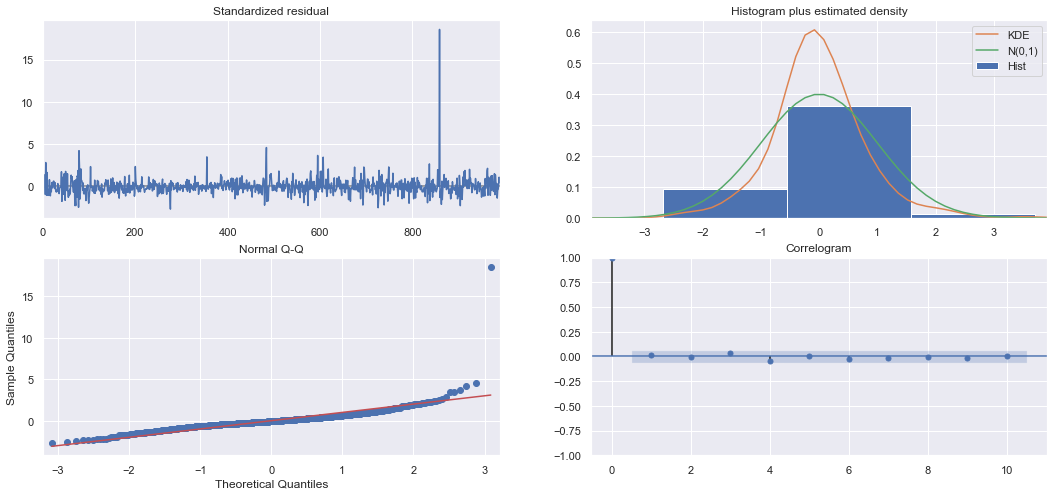

In [60]:
best_model.plot_diagnostics(figsize=(18, 8))
plt.show()

### predict most recent 400 records( since the data is sorted by 'date' in descending order)

In [158]:
#predict most recent 400 records( since the data is sorted by 'date' in descending order)
yhat = best_model.predict(start=1, end=400)
predicted_y=yhat.reset_index()

In [160]:
predicted_y[0]

0      18.870000
1      18.810000
2      18.740000
3      18.490000
4      28.085000
         ...    
395    13.466195
396    13.365540
397    13.339246
398    13.400230
399    13.497624
Name: 0, Length: 400, dtype: float64

In [136]:
data_actual=pd.read_csv('/Users/qq/Desktop/stock-prediction-master/stock_prices_sample.csv')
data_sorted=data_actual.sort_values(by=['DATE'],ascending=False)

In [161]:
pred_table=pd.DataFrame()
pred_table['date']=data_sorted['DATE'][1:400]
pred_table['pred']=predicted_y[0]
pred_table['actual']=data_sorted['CLOSE'][1:400]

In [162]:
pred_table

,date,pred,actual
4,2018-06-04,28.085000,18.8100
5,2018-06-01,18.196200,18.7400
6,2018-05-31,18.772000,18.4900
7,2018-05-30,18.500000,18.6500
8,2018-05-29,19.070000,18.2562
...,...,...,...
398,2016-11-07,13.400230,13.4900
399,2016-11-04,13.497624,13.3700
400,2016-11-03,NaN,13.3900
401,2016-11-02,NaN,13.4000


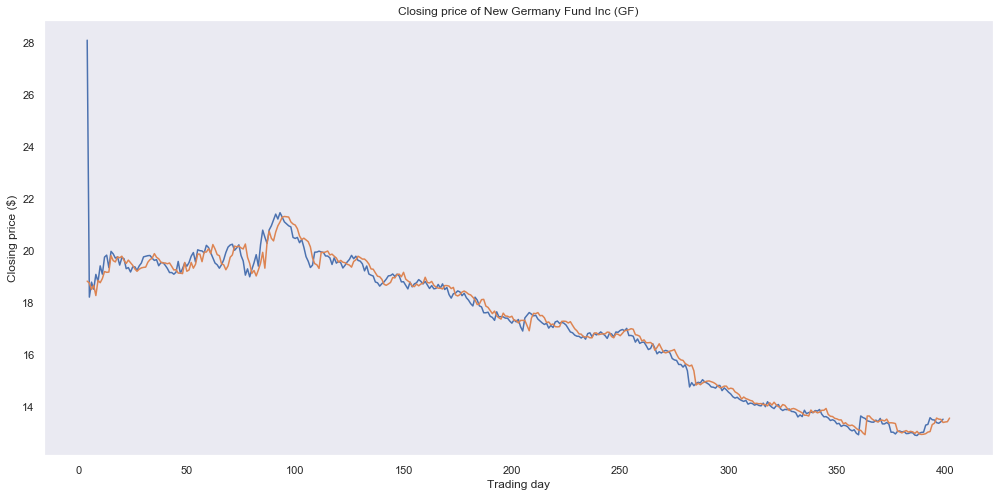

In [163]:
plt.figure(figsize=(17, 8))
plt.plot(pred_table['pred'])
plt.plot(pred_table['actual'])

plt.title('Closing price of New Germany Fund Inc (GF)')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
plt.grid(False)
plt.show()

## Evaluate the model (use Ljung-box test)

In [174]:
p_value=sm.stats.acorr_ljungbox(best_model.resid, lags=[2])[1]
p_value

array([0.85203694])

### p-value is big, so we do not reject H0(model is good). So the model is fine.